In [39]:
%matplotlib notebook

import matplotlib.pyplot as plt

import os
import json
import datetime

import numpy as np

In [11]:
paths = [
    os.path.join('..', 'command.out'),
    os.path.join('..', 'command.101932170.out'),
    os.path.join('..', 'command.114164404.out')
]

In [12]:
class FilterHelper():
    def __init__(self):
        self.cache = dict()
    
    def check(self, key):
        exists = self.cache.get(key, False)
        if not exists:
            self.cache[key] = True
        return exists
    
class AugmentHelper():
    def augment(self, msg):
        msg['date'] = ts2date(msg['timestamp'])
        return msg
    
def ts2date(ts):
    return datetime.datetime.fromtimestamp(int(ts)).strftime('%Y-%m-%d')

def uniqify(messages):
    helper = FilterHelper()
    return [m for m in messages if not helper.check(m['id'])]

def augment(messages):
    helper = AugmentHelper()
    return [helper.augment(m) for m in messages]

def read_messages(paths):
    # Read All
    messages = []
    for path in paths:
        with open(path) as f:
            messages += json.loads(f.read())['messages']
    print("Read {} messages.".format(len(messages)))
    messages = augment(uniqify(messages))
    print("{} unique messages.".format(len(messages)))
    return messages

messages = read_messages(paths)
len(messages)

Read 23670 messages.
23668 unique messages.


23668

In [13]:
messages[0]

{'avatar_url': 'https://zulip-avatars.s3.amazonaws.com/13/ea5ab7f7d6e19ffdee32487a6e145475c956689b?x=x&version=1',
 'client': 'website',
 'content': "Checkins, Monday through Thursday, at 10:30pm EST. One thread per day. Will have to figure out the multi-region issue, but we'll get there.",
 'content_type': 'text/x-markdown',
 'date': '2015-06-12',
 'display_recipient': 'alumni-checkins',
 'flags': ['read'],
 'id': 41022136,
 'is_me_message': False,
 'reactions': [],
 'recipient_id': 41651,
 'sender_email': 'andrew@mrdrozdov.com',
 'sender_full_name': "Andrew Drozdov (SP1'15)",
 'sender_id': 7630,
 'sender_realm_str': 'recurse',
 'sender_short_name': 'andrew',
 'stream_id': 27333,
 'subject': 'Overview',
 'subject_links': [],
 'timestamp': 1434148194,
 'type': 'stream'}

In [14]:
alumni_bot_messages = [m for m in messages if 'alumni-bot' in m['sender_email']]
alumni_bot_ids = [m['id'] for m in alumni_bot_messages]
print(len(alumni_bot_messages))
print(alumni_bot_messages[-1])

1117
{'client': 'curl', 'sender_full_name': 'Alumni Bot', 'subject_links': [], 'sender_id': 8152, 'avatar_url': 'https://secure.gravatar.com/avatar/c2d3df6c859969f56dbdb7b39ab39319?d=identicon&version=1', 'id': 123857291, 'recipient_id': 41651, 'stream_id': 27333, 'sender_realm_str': 'recurse', 'sender_email': 'alumni-bot@students.hackerschool.com', 'sender_short_name': 'alumni-bot', 'flags': ['read'], 'content': 'Welcome to [checkins](https://gist.githubusercontent.com/mrdrozdov/bfd8d218a9414ce11b4d/raw/a23ff8cf560ef6fa60893bade9d05c5fc7f12313/alumin-checkins.txt)!', 'timestamp': 1521329401, 'content_type': 'text/x-markdown', 'reactions': [], 'type': 'stream', 'subject': 'Checkins! Sunday. March 18, 2018', 'is_me_message': False, 'display_recipient': 'alumni-checkins', 'date': '2018-03-17'}


In [15]:
user_messages = [m for m in messages if m['id'] not in alumni_bot_ids]

weekly_checkins = [m for m in user_messages if m['subject'].startswith('Checkins! Week')]
weekly_ids = set(m['id'] for m in weekly_checkins)
daily_checkins = [m for m in user_messages if m['subject'].startswith('Checkins!') and m['id'] not in weekly_ids]
daily_ids = set(m['id'] for m in daily_checkins)
periodic_ids = set.union(weekly_ids, daily_ids)
personal_checkins = [m for m in user_messages if m['id'] not in periodic_ids]

print(len(weekly_checkins), len(daily_checkins), len(personal_checkins))

149 17116 5286


In [22]:
def group_messages_by_date(messages):
    messages_by_date = {}
    for m in messages:
        messages_by_date.setdefault(m['date'], []).append(m)
    return messages_by_date

<IPython.core.display.Javascript object>


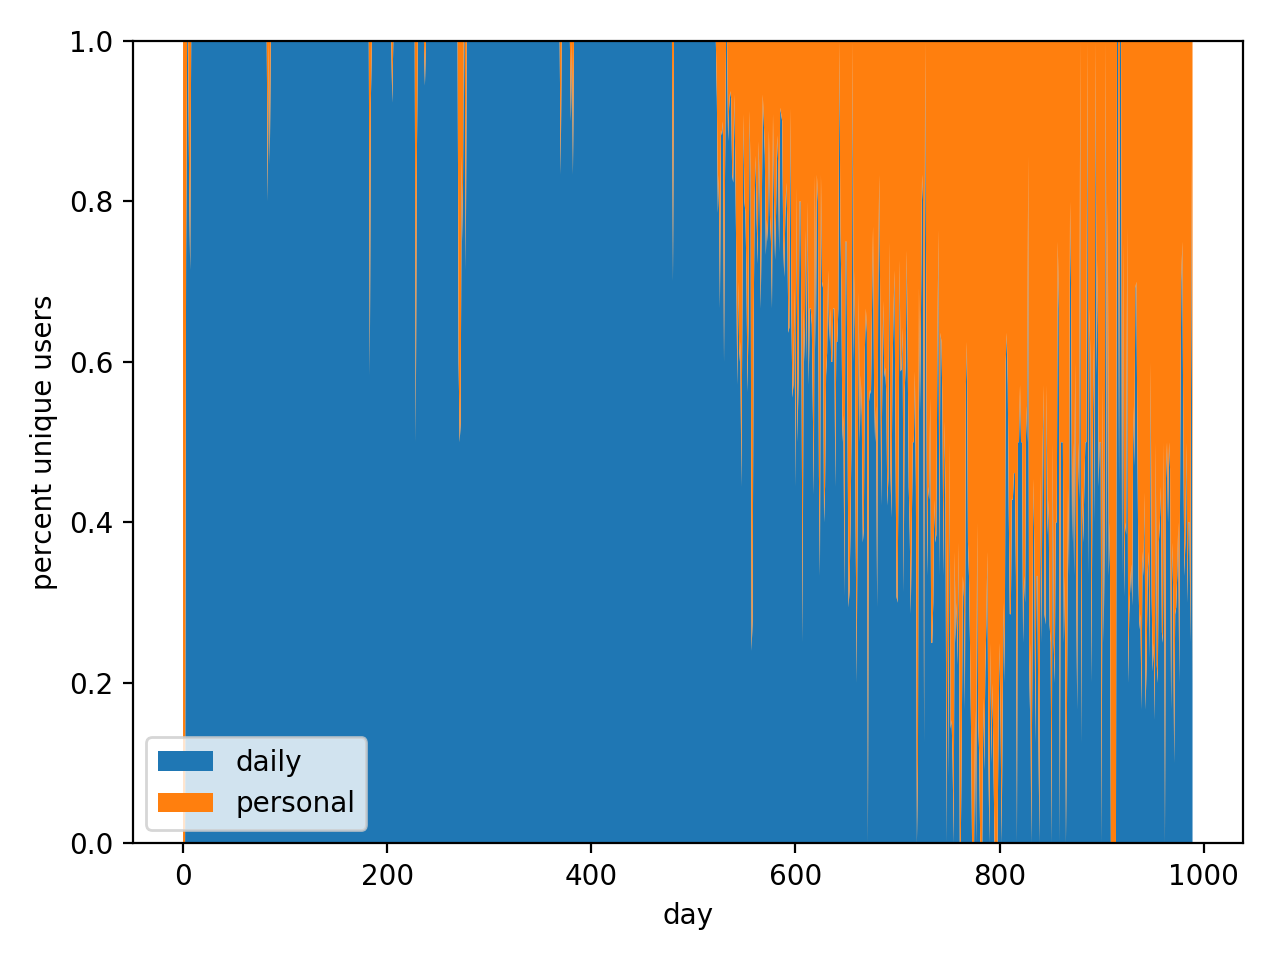

In [71]:
def plot_messages_by_date(messages_by_date):
    keys = sorted(messages_by_date.keys())
    ys = [len(messages_by_date[date]) for date in keys]
    xs = range(len(ys))
    
    plt.figure()
    plt.plot(xs, ys)
    plt.tight_layout()
    plt.show()
    
def plot_multi_messages_by_date(message_groups, labels=None, ymax=None):
    if labels is None:
        labels = map(str, range(len(message_groups)))
    
    keys = sorted(set.union(*map(lambda grp: set(grp.keys()), message_groups)))
    xs = range(len(keys))
    
    ys_arr = []
    for grp in message_groups:
        ys_arr.append([
            len(set(map(lambda m: m['sender_id'], grp.get(key, []))))
            for key in keys])
    
    ys_arr_percent = []
    sums = [sum(ys[i] for ys in ys_arr) for i in range(len(keys))]
    for ys in ys_arr:
        ys_arr_percent.append([float(ys[i])/sums[i] for i in range(len(keys))])
        
    
    plt.figure()
    
    plt.stackplot(xs, *ys_arr_percent, labels=labels)
#     plt.stackplot(xs, *ys_arr, labels=labels, baseline='wiggle')
    
    plt.legend(loc='lower left')
    plt.xlabel('day')
#     plt.ylabel('unique users')
    plt.ylabel('percent unique users')
#     plt.ylim(ymin=-ymax, ymax=ymax)
    plt.ylim(ymin=0, ymax=1)
    plt.tight_layout()
    plt.show()
    
plot_multi_messages_by_date(
    [group_messages_by_date(daily_checkins), group_messages_by_date(personal_checkins)],
    ['daily', 'personal'],
    ymax=50
                           )


In [104]:
weekly = [0]
daily = [0]
personal = [0]

for m in user_messages:
    w = weekly[-1]
    d = daily[-1]
    p = personal[-1]
    
    if m['subject'].startswith('Checkins! Week'):
        w = w + 1
    elif m['subject'].startswith('Checkins!'):
        d = d + 1
    else:
        p = p + 1
    
    weekly += [w]
    daily += [d]
    personal += [p]
    
len(weekly)
len(daily)
len(personal)

22552

<IPython.core.display.Javascript object>


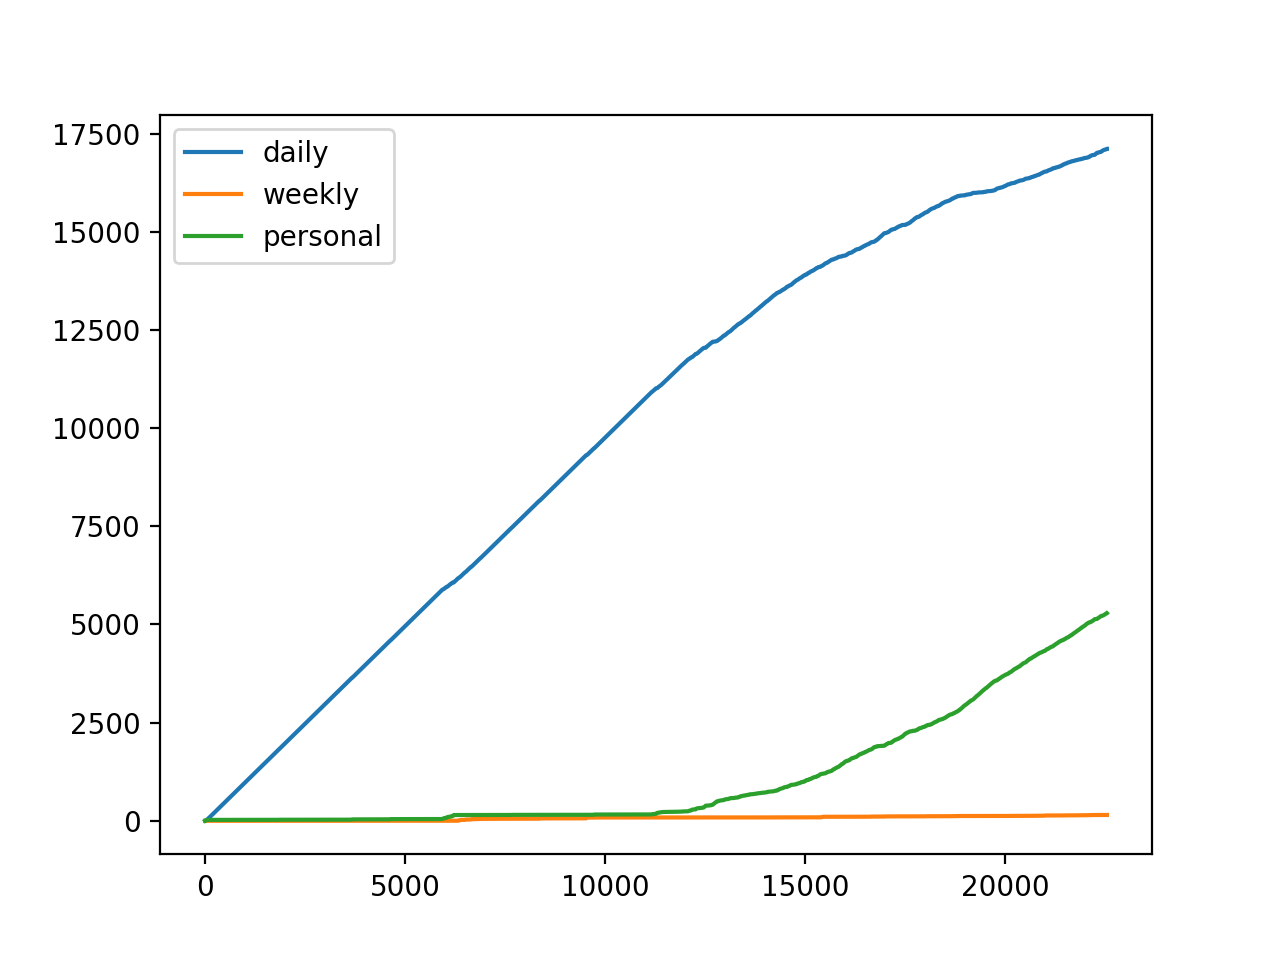

In [105]:
plt.figure()
plt.plot(range(len(daily)), daily, label='daily')
plt.plot(range(len(weekly)), weekly, label='weekly')
plt.plot(range(len(personal)), personal, label='personal')
plt.legend(loc='best')
plt.show()

In [117]:
n_last = len(user_messages)
min_ts = user_messages[-n_last]['timestamp']
first_x = [0]

weekly_x = [0]
daily_x = [0]
personal_x = [0]

weekly_y = [0]
daily_y = [0]
personal_y = [0]

for m in user_messages[-n_last:]:
    w = weekly_y[-1]
    d = daily_y[-1]
    p = personal_y[-1]
    ts = m['timestamp'] - min_ts
    
    if m['subject'].startswith('Checkins! Week'):
        w = w + 1
    elif m['subject'].startswith('Checkins!'):
        d = d + 1
    else:
        p = p + 1
        
    weekly_x += [ts]
    daily_x += [ts]
    personal_x += [ts]
    
    weekly_y += [w]
    daily_y += [d]
    personal_y += [p]

<IPython.core.display.Javascript object>


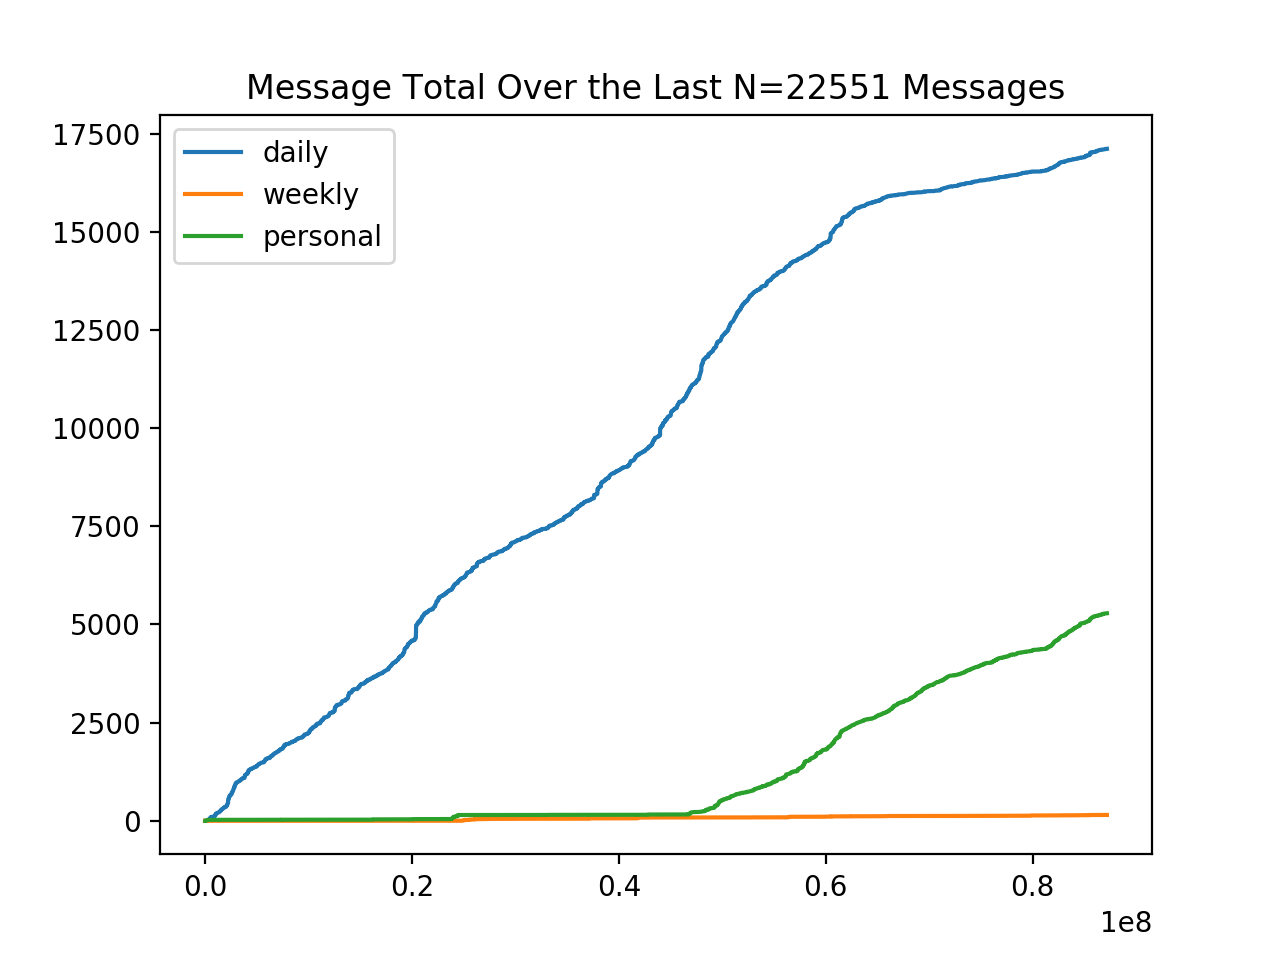

In [118]:
plt.figure()
plt.title('Message Total Over the Last N={} Messages'.format(n_last))
plt.plot(daily_x, daily_y, label='daily')
plt.plot(weekly_x, weekly_y, label='weekly')
plt.plot(personal_x, personal_y, label='personal')
plt.legend(loc='best')
plt.show()